In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

DIR = "/content/drive/MyDrive/Competitions/Signate/OCEAN180"
INPUT_DIR = os.path.join(DIR,"input")
OUTPUT_DIR = os.path.join(DIR,"output")

if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [4]:
train = pd.read_csv(os.path.join(INPUT_DIR,"train_data.csv"))
test = pd.read_csv(os.path.join(INPUT_DIR,"test_data.csv"))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR,"submit_example.csv"), header=None)

print(train.shape)
display(train.head(3))

print(test.shape)
display(test.head(3))

print(sample_sub.shape)
display(sample_sub.head(3))

(14140, 3465)


,Unnamed: 0,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.0,...,0.507961,0.287288,-0.278071,-0.808075,-2.341663,2.353039,95.142525,3.728732,-2.405135,3725_10
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.0,...,0.353645,0.245048,-0.100556,-0.771423,-3.282602,4.672225,174.767501,-0.571513,0.448861,4027_13
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.0,...,0.579204,0.281260,-0.191884,-0.853730,-3.160207,3.324236,62.711236,3.284478,-57.136191,3927_22


(4039, 3464)


,Unnamed: 0,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_NormG_2020,MIN_NormR_2020,MIN_PPR_2020,MIN_PSNDc2_2020,MIN_RDVI_2020,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,0.409346,0.323023,-0.066356,-0.560810,-3.203797,4.297234,926.905329,1.669992,0.194766,3624_20
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,0.540733,0.275585,-0.291240,-0.824888,-2.222276,2.263106,57.661693,4.274851,-79.273275,3624_20
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,0.601792,0.252251,-0.318454,-0.861477,-2.060505,2.099250,42.672829,5.655713,-2.061417,3927_23


(4039, 2)


,0,1
0,0,0.47
1,1,0.68
2,2,0.25


In [5]:
train.rename(columns={"Unnamed: 0":"id"}, inplace=True)
test.rename(columns={"Unnamed: 0":"id"}, inplace=True)

In [6]:
def missing_func(df):
  total = df.isnull().sum().sort_values(ascending=False)
  percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
  df_missing = pd.concat([total,percent],axis=1,keys=['total','percent'])
  return df_missing 

In [7]:
train_missing = missing_func(train)
test_missing = missing_func(test)

In [8]:
train_cols = train.columns.tolist()
test_cols = test.columns.tolist()

target = set(train_cols) - set(test_cols)
print(target)

display(train[target].head(3))

{'cover'}


,cover
0,0.050
1,0.725
2,0.025


In [9]:
train["adv_flag"] = 0
test["adv_flag"] = 1

df = pd.concat([train,test]).reset_index(drop=True)

In [10]:
area_mean = df.area.mean()
train["area"] = train["area"].fillna(area_mean)
test["area"] = test["area"].fillna(area_mean)

train["cover_area"] = train.cover * train.area
train["cover_area_log"] = np.log1p(train['cover_area'])

In [11]:
train_missing_50 = train_missing[train_missing.percent<0.5].index
test_missing_50 =  test_missing[test_missing.percent<0.5].index

categorical_features = train.dtypes[train.dtypes=="object"].index

features = set(train_missing_50) & set(test_missing_50)
features = set(features) - set(categorical_features) 

In [12]:
tr_mesh = train.mesh20.value_counts().index
te_mesh = test.mesh20.value_counts().index

test_only_mesh = list(set(te_mesh)-set(tr_mesh))
test_mesh = list(set(te_mesh)-set(test_only_mesh))

In [13]:
def get_mesh_values(df):
  _df = df["mesh20"].str.split('_').apply(pd.Series).astype(float)
  _df.columns = ["mesh20_left","mesh20_right"]
  df["mesh20_left"] = _df["mesh20_left"].astype(int)
  df["mesh20_right"] = _df["mesh20_right"].astype(int)
  return df

In [14]:
train = get_mesh_values(train)
test = get_mesh_values(test)

In [15]:
tr_mesh_l = train.mesh20_left.value_counts().index
te_mesh_l = test.mesh20_left.value_counts().index

tr_mesh_r = train.mesh20_right.value_counts().index
te_mesh_r = test.mesh20_right.value_counts().index

print(set(te_mesh_l)-set(tr_mesh_l))
print(set(te_mesh_r)-set(tr_mesh_r))

set()
set()


## Model

In [16]:
#!pip install iterative-stratification

In [17]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold, KFold
#from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, precision_score, recall_score

In [18]:
class CFG:
  ver=24
  model="lightgbm"
  n_folds=4
  trn_fold=[0, 1, 2, 3]
  seed=42
  target_cols1="adv_flag"
  target_cols2="cover_area_log"
  boosting_type="gbdt"
  fold_target1="adv_flag"
  fold_target2="cover_area_log"
  fold_target3="cover_area_log"

In [19]:
# =========================================================================================
# CV split
# =========================================================================================
def get_fold(df,fold_target, isFlag=False):
  if isFlag:
    Fold = StratifiedGroupKFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate(Fold.split(df, df[fold_target], groups=df["mesh20"])):
        df.loc[val_index, 'fold'] = int(n)
  else:
    Fold = KFold(n_splits=CFG.n_folds, shuffle=True, random_state=CFG.seed)
    for n, (train_index, val_index) in enumerate(Fold.split(df)):
      df.loc[val_index, 'fold'] = int(n)
  df['fold'] = df['fold'].astype(int)
  display(df.groupby('fold').size())
  return df

In [20]:
def get_score(labels, preds, isFlag=False):
  if isFlag:
    f1score = f1_score(labels, preds)
    pscore = precision_score(labels, preds)
    rscore =recall_score(labels, preds)
    print(f"F1 Score : {f1score}")
    print(f"Precision Score : {pscore}")
    print(f"Recall Score {rscore}")
  else:
    rmse = np.sqrt(mean_squared_error(labels, preds))
    print(f"RMSE {rmse}")

In [21]:
features = list(features)
features.remove('id')
features.remove('area')
remove_missing_features = features

In [22]:
params1 = {
        'objective': "binary",
        'metric': 'binary_logloss',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.5,
        "n_estimators":1000
    }

params2 = {
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.1,
        'boosting': CFG.boosting_type,
        'seed': CFG.seed,
        "reg_alpha":0.5,
        "n_estimators":1000
    }

In [23]:
def get_pred(df, test, fold_target, target_cols, model, isFlag=False):
  if isFlag:
    pred_name = "flag"
    train = get_fold(df, fold_target, isFlag=True)
  else:
    pred_name = ""
    train = get_fold(df, fold_target, isFlag=False)
  oof_df = pd.DataFrame()
  df_importance = pd.DataFrame({'feature': features})
  df_importance['importance'] = 0
  test_preds = np.zeros((len(test), CFG.n_folds))

  for fold in range(CFG.n_folds):
    if fold in CFG.trn_fold:
      print("="*15,f" FOLD : {fold} ","="*15)
      train_folds = train[train['fold'] != fold]
      valid_folds = train[train['fold'] == fold]

      train_X = train_folds[features].values
      valid_X = valid_folds[features].values
      test_X = test[features].values
      train_labels = train_folds[target_cols].values
      valid_labels = valid_folds[target_cols].values

      clf = model
      #model = lgb.LGBMRegressor(**params)
      clf.fit(train_X, train_labels,
              eval_set=[(valid_X, valid_labels)],
              #eval_metric="rmse",
              verbose = 200,
              early_stopping_rounds=50)
      
      if isFlag:
        pred = model.predict(valid_X)
        predict_proba = model.predict_proba(valid_X)
        valid_folds["Zscore"] = predict_proba[:,1]
        valid_folds[f"{pred_name}_pred"] = pred
      else:
        valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)
        test_preds[:, fold] = model.predict(test_X)
      oof_df = pd.concat([oof_df, valid_folds])

      f_importance = np.array(model.feature_importances_)
      temp_importance = pd.DataFrame({'feature': features, 'importance': f_importance})
      df_importance['importance'] += temp_importance['importance']

      get_score(valid_labels, valid_folds[f"{pred_name}_pred"], isFlag)

  df_importance['importance'] = df_importance['importance'] / np.sum(df_importance['importance'])
  df_importance = df_importance.sort_values('importance', ascending=False)
  imp_features50 = df_importance.iloc[:50].feature.tolist()
  display(df_importance.head(35))
  fig = plt.figure(figsize=(16, 32), tight_layout=True)
  sns.barplot(x="importance", y="feature", data=df_importance.head(35))
  plt.title("LightGBM feature importances")
  get_score(oof_df[target_cols], oof_df[f"{pred_name}_pred"], isFlag)
  if isFlag:
    return oof_df, imp_features50
  else:
    return oof_df,  test_preds, imp_features50

In [24]:
# 傾向スコアマッチング関数
def matching(result1, z_col='Zscore', tr_col="adv_flag", match_id='id'):
    '''
    result1: 介入変数、傾向スコア、共変量のデータフレーム
    '''
    # キャリパー設定
    caliper = result1[z_col].std()*0.2

    # 処置群抽出
    Tr = result1[result1[tr_col]>0][[match_id, z_col]].copy().reset_index(drop=True)
    Tr.index = Tr[match_id]
    # 対照群抽出
    Ctl = result1[result1[tr_col]==0][[match_id, z_col]].copy().reset_index(drop=True)
    Ctl.index = Ctl[match_id]
    
    Ctl_vals = np.copy(Ctl[z_col].to_numpy()) # 配列化
    Ctl_ids = np.copy(Ctl.index.to_numpy()) # 配列化
    Tr_vals_dict = Tr[z_col].sort_values(ascending=False).to_dict() # 処置群の傾向スコアで降順にして辞書化

    # マッチングを実施していく
    match_results = [] # 結果を入れる箱
    for i, (cid, tr_val) in tqdm(enumerate(Tr_vals_dict.items())):
        # cid:user_id, tr_val:傾向スコア
        # argminで処置群と最も傾向スコアの差が小さい対照群のインデックス番号取得
        nearId = np.abs(Ctl_vals - tr_val).argmin()
        # 傾向スコアの差がキャリパーより大きかった場合、マッチングしない
        if np.abs(tr_val-Ctl_vals[nearId])>caliper:
            continue
        # 傾向スコアの差がキャリパーより小さかった場合、マッチングした者同士をリストに格納
        match_results.append([cid, Ctl_ids[nearId], tr_val, Ctl_vals[nearId]])
        # 次のマッチングで重複してマッチングしないように対照群のスコアを-9999に置き換える
        np.put(Ctl_vals, [nearId], -9999)

    # リストをdf化
    match_results_df = pd.DataFrame(match_results, columns=['Tr', 'Ctl', 'Tr_zscore', 'Ctl_zscore'])
    match_results_df['diff'] = np.abs(match_results_df['Tr_zscore']-match_results_df['Ctl_zscore'])
    print(match_results_df['diff'].max())
    return match_results_df

fold
0    3535
1    3535
2    3535
3    3535
dtype: int64

===============  FOLD : 0  ===============
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.40338
[400]	valid_0's rmse: 0.398379
[600]	valid_0's rmse: 0.39682
Early stopping, best iteration is:
[653]	valid_0's rmse: 0.396521


<ipython-input-23-908f9e09da6e>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.39652111271893264
===============  FOLD : 1  ===============
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.394909
[400]	valid_0's rmse: 0.390681
Early stopping, best iteration is:
[502]	valid_0's rmse: 0.389888


<ipython-input-23-908f9e09da6e>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.3898875299277828
===============  FOLD : 2  ===============
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.390656
[400]	valid_0's rmse: 0.384675
Early stopping, best iteration is:
[496]	valid_0's rmse: 0.383978


<ipython-input-23-908f9e09da6e>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.3839781793960701
===============  FOLD : 3  ===============
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.396769
[400]	valid_0's rmse: 0.389784
[600]	valid_0's rmse: 0.388278
[800]	valid_0's rmse: 0.387889
[1000]	valid_0's rmse: 0.387714
Did not meet early stopping. Best iteration is:
[978]	valid_0's rmse: 0.387672


<ipython-input-23-908f9e09da6e>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.3876716421749243


,feature,importance
2674,month,0.005959
2382,sst_ymd,0.003753
1554,sst_diff,0.003411
2823,VARIgreen,0.002878
81,MAX_CI,0.002625
2644,year,0.002371
788,GLI,0.002257
724,H,0.002143
65,TIRS2,0.002079
2950,Blue,0.002041


RMSE 0.3895413403042003


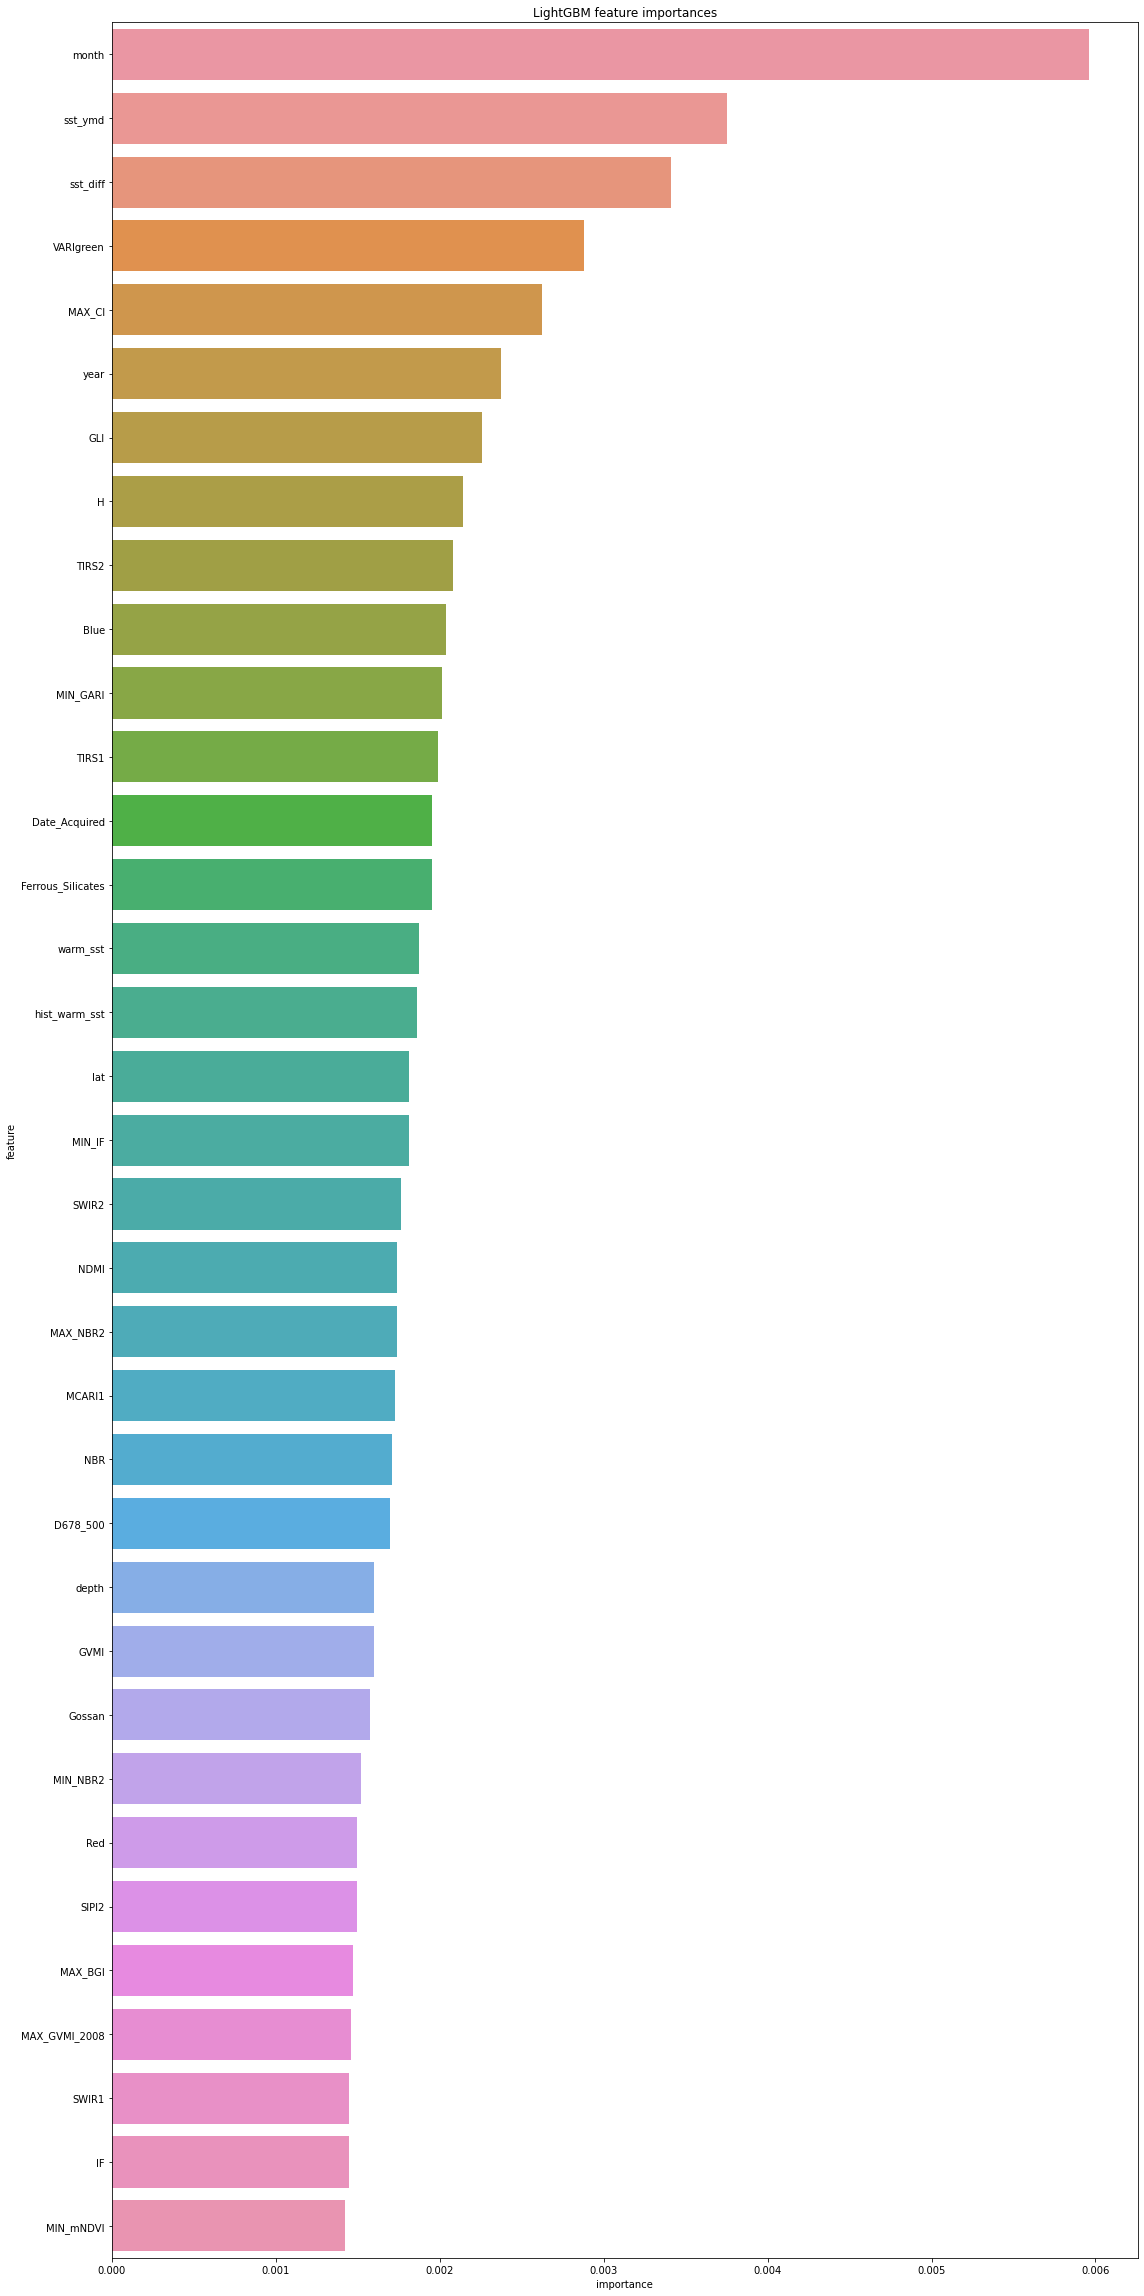

In [25]:
model = lgb.LGBMRegressor(**params2)
select_feats_train, select_feats_test, imp_features  = get_pred(train, test, CFG.fold_target3, CFG.target_cols2, model)

In [26]:
new_features = [col for col in imp_features if col not in ["month","lat","lon","year"]]
print(len(train[new_features].round(3)))
print(len(train[new_features].round(3).drop_duplicates()))
print(len(test[new_features].round(3)))
print(len(test[new_features].round(3)[~train[new_features].round(3).duplicated()]))

14140
13415
4039
3947


<ipython-input-26-f17b86bd7598>:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(len(test[new_features].round(3)[~train[new_features].round(3).duplicated()]))


In [27]:
tmp_train_id = train[new_features].round(3).drop_duplicates().index.tolist()
train = train.loc[train["id"].isin(tmp_train_id)].reset_index(drop=True)
concat_df = pd.concat([train,test]).reset_index(drop=True)
features = imp_features

fold
0    5499
1    5251
2     993
3    5711
dtype: int64

===============  FOLD : 0  ===============
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.680129
F1 Score : 0.0
Precision Score : 0.0
Recall Score 0.0
===============  FOLD : 1  ===============


<ipython-input-23-908f9e09da6e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds["Zscore"] = predict_proba[:,1]
<ipython-input-23-908f9e09da6e>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = pred
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[2]	valid_0's binary_logloss: 0.397251
F1 Score : 0.0
Precision Score : 0.0
Recall Score 0.0
===============  FOLD : 2  ===============


<ipython-input-23-908f9e09da6e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds["Zscore"] = predict_proba[:,1]
<ipython-input-23-908f9e09da6e>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = pred
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.666352
F1 Score : 0.0
Precision Score : 0.0
Recall Score 0.0
===============  FOLD : 3  ===============


<ipython-input-23-908f9e09da6e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds["Zscore"] = predict_proba[:,1]
<ipython-input-23-908f9e09da6e>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = pred
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[1]	valid_0's binary_logloss: 0.74774
F1 Score : 0.0
Precision Score : 0.0
Recall Score 0.0


<ipython-input-23-908f9e09da6e>:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds["Zscore"] = predict_proba[:,1]
<ipython-input-23-908f9e09da6e>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = pred
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

,feature,importance
16,lat,0.186667
2,sst_diff,0.140000
14,warm_sst,0.113333
15,hist_warm_sst,0.106667
5,year,0.086667
0,month,0.080000
1,sst_ymd,0.080000
24,depth,0.046667
45,MIN_IF_2017,0.033333
20,MAX_NBR2,0.020000


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 Score : 0.0
Precision Score : 0.0
Recall Score 0.0


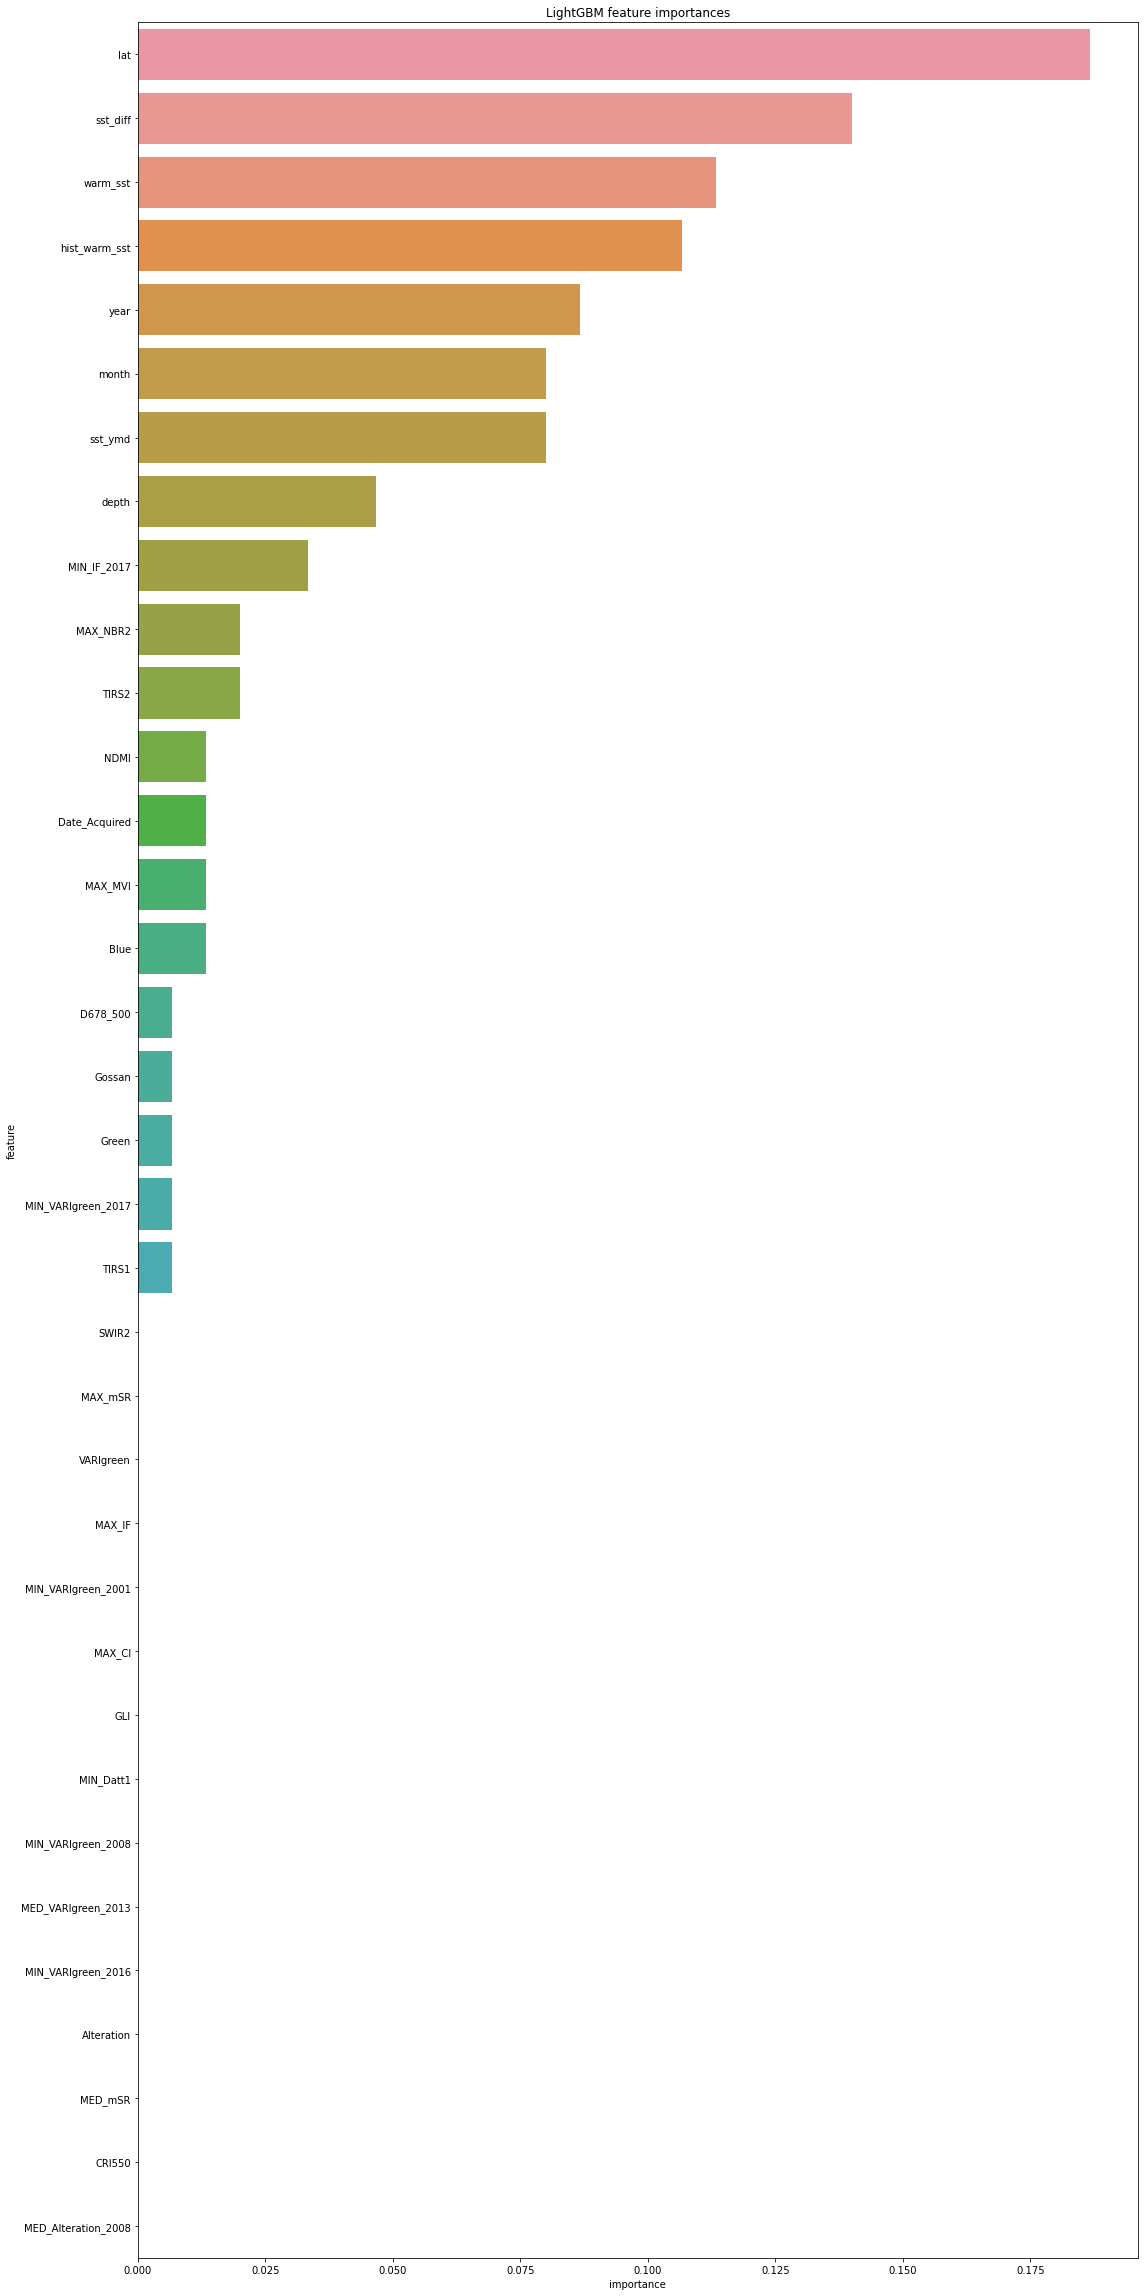

In [28]:
model1 = lgb.LGBMClassifier(**params1)
flag_oof, imp_features = get_pred(concat_df, test, CFG.fold_target1, CFG.target_cols1, model1, isFlag=True)

In [29]:
match_results_df = matching(flag_oof, z_col='Zscore', tr_col='adv_flag', match_id='id')
display(match_results_df)

4039it [00:00, 13984.95it/s]

0.005171231140887633


,Tr,Ctl,Tr_zscore,Ctl_zscore,diff
0,1990,74,0.458460,0.458782,0.000322
1,1993,127,0.458460,0.458782,0.000322
2,1934,824,0.446406,0.446406,0.000000
3,2291,3387,0.446406,0.446406,0.000000
4,1684,3403,0.446406,0.446406,0.000000
...,...,...,...,...,...
4034,2292,3754,0.159377,0.159377,0.000000
4035,112,3782,0.159377,0.159377,0.000000
4036,663,3826,0.159377,0.159377,0.000000
4037,904,3854,0.159377,0.159377,0.000000


In [30]:
match_id = match_results_df.Ctl.tolist()
match_train = train[train["id"].isin(match_id)].reset_index(drop=True)
display(match_train)

,id,lat,lon,area,YMD,year,month,cover,depth_original,cliff_length,...,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,adv_flag,cover_area,cover_area_log,mesh20_left,mesh20_right,fold
0,0,24.989139,125.243167,20.0,20110926,2011.0,9.0,0.050,NaN,0.000000,...,95.142525,3.728732,-2.405135,3725_10,0,1.0,0.693147,3725,10,0
1,1,26.996172,127.912024,40.0,2009.7.6-2009.7.28,2009.0,7.0,0.725,NaN,0.000000,...,174.767501,-0.571513,0.448861,4027_13,0,29.0,3.401197,4027,13,3
2,2,26.363556,127.735139,20.0,20091014,2009.0,10.0,0.025,NaN,0.000000,...,62.711236,3.284478,-57.136191,3927_22,0,0.5,0.405465,3927,22,2
3,3,26.991255,127.912302,40.0,2009.1.13-2009.2.19,2009.0,1.0,0.575,NaN,0.000000,...,51.879647,6.054869,-5.697032,4027_13,0,23.0,3.178054,4027,13,1
4,4,26.988254,127.917254,40.0,2009.1.13-2009.2.19,2009.0,1.0,0.225,NaN,0.000000,...,50.467718,8.537779,-1.617806,4027_13,0,9.0,2.302585,4027,13,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,14118,24.910889,125.255639,20.0,20110618,2011.0,6.0,0.050,NaN,845.273254,...,60.273371,2.276926,-11.097145,3725_11,0,1.0,0.693147,3725,11,3
4035,14122,27.016972,127.949611,20.0,20110907,2011.0,9.0,0.050,NaN,0.000000,...,80.781064,4.338511,-15.462196,4027_23,0,1.0,0.693147,4027,23,0
4036,14126,27.040250,127.994389,20.0,20110909,2011.0,9.0,0.050,NaN,0.000000,...,77.728761,4.738363,-6.133056,4027_23,0,1.0,0.693147,4027,23,1
4037,14130,25.013556,125.238306,20.0,20110928,2011.0,9.0,0.050,NaN,0.000000,...,62.835948,1.834245,-2.585345,3725_20,0,1.0,0.693147,3725,20,1


fold
0    1010
1    1010
2    1010
3    1009
dtype: int64

===============  FOLD : 0  ===============
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.425649
[400]	valid_0's rmse: 0.424551
Early stopping, best iteration is:
[353]	valid_0's rmse: 0.424546


<ipython-input-23-908f9e09da6e>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.42454591801447633
===============  FOLD : 1  ===============
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.432489
Early stopping, best iteration is:
[222]	valid_0's rmse: 0.432229


<ipython-input-23-908f9e09da6e>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.43222881568663707
===============  FOLD : 2  ===============
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.378248
Early stopping, best iteration is:
[330]	valid_0's rmse: 0.377168


<ipython-input-23-908f9e09da6e>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.37716755521901535
===============  FOLD : 3  ===============
Training until validation scores don't improve for 50 rounds.
[200]	valid_0's rmse: 0.390867
[400]	valid_0's rmse: 0.388498
Early stopping, best iteration is:
[393]	valid_0's rmse: 0.388498


<ipython-input-23-908f9e09da6e>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_folds[f"{pred_name}_pred"] = model.predict(valid_X)


RMSE 0.388497943394039


,feature,importance
81,MAX_CI,0.004691
65,TIRS2,0.004382
96,TIRS1,0.004201
1554,sst_diff,0.004175
2674,month,0.003866
2171,Date_Acquired,0.003763
2382,sst_ymd,0.003351
857,warm_sst,0.003196
503,Ferrous_Silicates,0.003196
43,NDMI,0.003144


RMSE 0.4062822285661269


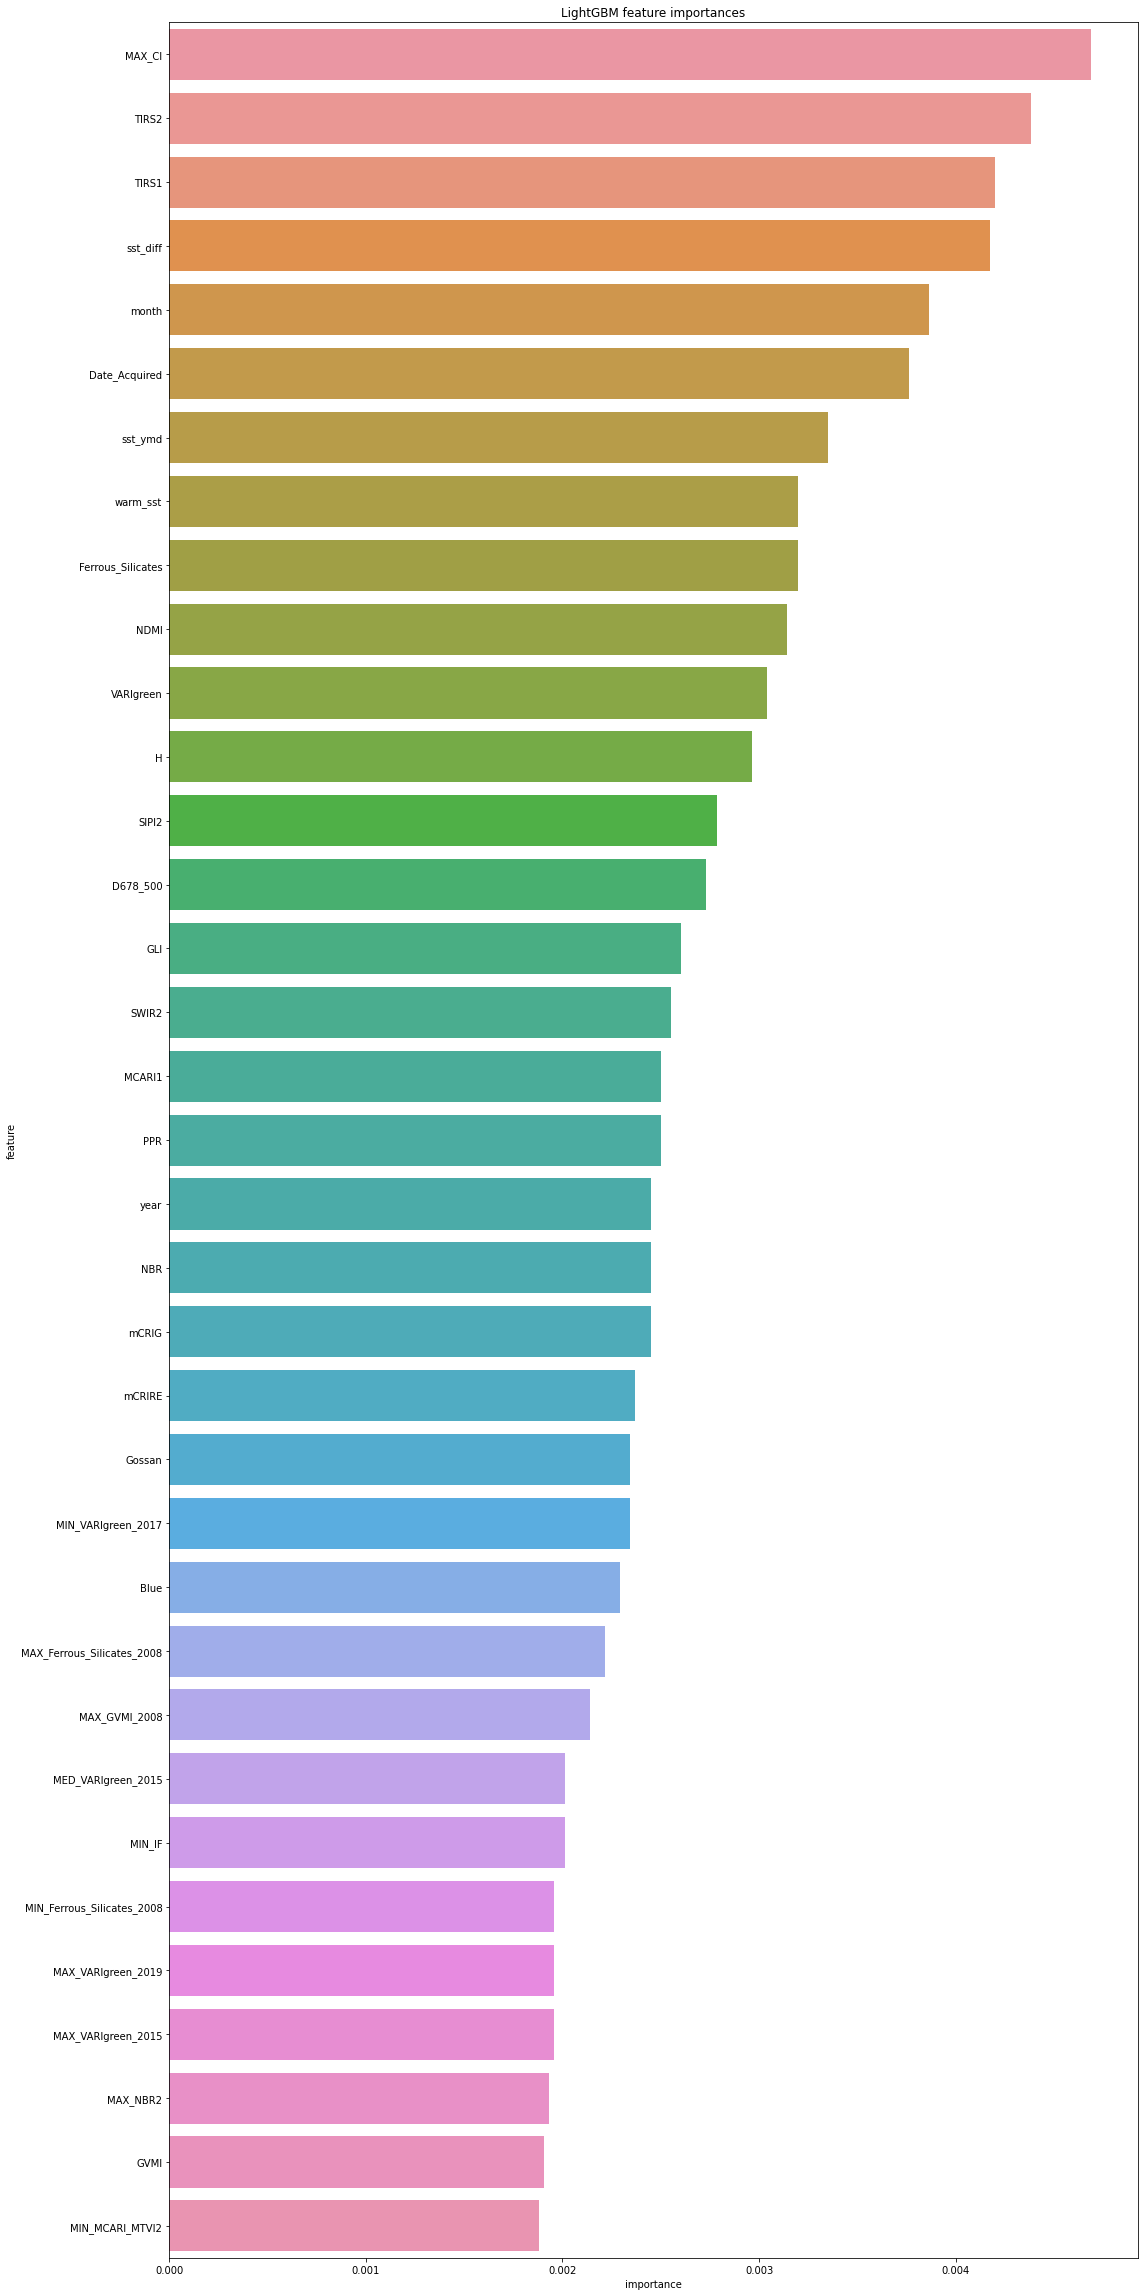

In [31]:
features = remove_missing_features
model2 = lgb.LGBMRegressor(**params2)
oof_df, test_pred,_ = get_pred(match_train, test, CFG.fold_target3, CFG.target_cols2, model2)

In [32]:
cover_max = train.cover.max()
_oof = oof_df.copy()
_oof["pred"] = np.expm1(_oof["_pred"]) / _oof["area"]
_oof["pred"] = _oof["pred"].apply(lambda x: x if x>0 else 0)
_oof["pred"] = _oof["pred"].apply(lambda x: x if x<1 else cover_max)
get_score(_oof["cover"], _oof["pred"])

RMSE 0.12579325585607526


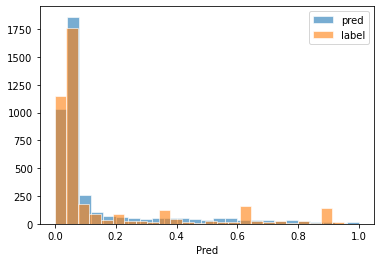

In [33]:
plt.hist(_oof.pred, label='pred', bins=25, edgecolor='white', alpha=.6)
plt.hist(_oof.cover, label="label", bins=25, edgecolor='white', alpha=.6)
plt.xlabel("Pred")
plt.legend()
plt.show()

In [34]:
pred_df = test.copy()
pred_df["pred_area_log"] = np.mean(test_pred, axis=1)

pred_df["pred"] = np.expm1(pred_df["pred_area_log"]) / pred_df['area']
pred_df = pred_df.sort_index()
pred_df

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,adv_flag,mesh20_left,mesh20_right,pred_area_log,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,4.297234,926.905329,1.669992,0.194766,3624_20,1,3624,20,0.189421,0.010427
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,2.263106,57.661693,4.274851,-79.273275,3624_20,1,3624,20,0.935952,0.077482
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,2.099250,42.672829,5.655713,-2.061417,3927_23,1,3927,23,0.503453,0.006544
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,-10.433323,45.061952,1.546086,-14.527890,3927_11,1,3927,11,1.010471,0.087345
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,2.563503,80.374689,1.827876,-6.335208,3725_01,1,3725,1,1.590011,0.195190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,3.633575,60.936945,3.053976,-28.354402,4027_03,1,4027,3,0.637179,0.044557
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,2.495430,75.231230,3.946128,-2.112646,3624_20,1,3624,20,0.584598,0.039713
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,4.403977,117.513676,1.904304,0.601280,3927_23,1,3927,23,1.074633,0.019289
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,2.203933,121.654726,2.282056,-2.029225,3623_03,1,3623,3,1.201183,0.116202


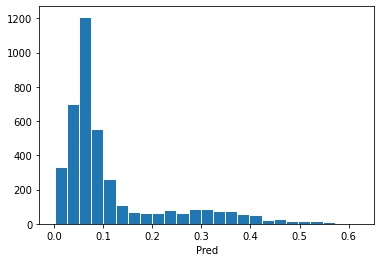

,id,lat,lon,area,YMD,year,month,depth_original,cliff_length,aicial_length,...,MIN_IF_2020,MIN_SLAVI_2020,MIN_SIPI2_2020,MIN_VARIgreen_2020,mesh20,adv_flag,mesh20_left,mesh20_right,pred_area_log,pred
0,0,24.352222,124.202674,20.0,2002.12,2002.0,12.0,0.5,0.000000,725.621704,...,4.297234,926.905329,1.669992,0.194766,3624_20,1,3624,20,0.189421,0.010427
1,1,24.420028,124.078583,20.0,20100723,2010.0,7.0,NaN,0.000000,0.000000,...,2.263106,57.661693,4.274851,-79.273275,3624_20,1,3624,20,0.935952,0.077482
2,2,26.494197,127.836013,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,13.8,73.183418,80.595177,...,2.099250,42.672829,5.655713,-2.061417,3927_23,1,3927,23,0.503453,0.006544
3,3,26.183639,127.319361,20.0,20100805,2010.0,8.0,NaN,0.000000,0.000000,...,-10.433323,45.061952,1.546086,-14.527890,3927_11,1,3927,11,1.010471,0.087345
4,4,24.761089,125.269009,20.0,NaN,2019.0,10.0,-0.5,0.000000,34.796036,...,2.563503,80.374689,1.827876,-6.335208,3725_01,1,3725,1,1.590011,0.195190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034,4034,26.702075,127.873347,20.0,NaN,2019.0,9.0,0.4,0.000000,20.594961,...,3.633575,60.936945,3.053976,-28.354402,4027_03,1,4027,3,0.637179,0.044557
4035,4035,24.337028,124.232694,20.0,20101122,2010.0,11.0,NaN,0.000000,0.000000,...,2.495430,75.231230,3.946128,-2.112646,3624_20,1,3624,20,0.584598,0.039713
4036,4036,26.493121,127.839918,100.0,"2004.2.20-2004.2.22,2004.2.27-2004.2.29,2004.3...",2004.0,2.0,0.1,76.439651,133.127228,...,4.403977,117.513676,1.904304,0.601280,3927_23,1,3927,23,1.074633,0.019289
4037,4037,24.068778,123.804194,20.0,20110415,2011.0,4.0,NaN,73.660492,0.000000,...,2.203933,121.654726,2.282056,-2.029225,3623_03,1,3623,3,1.201183,0.116202


In [35]:
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x>0 else 0)
pred_df["pred"] = pred_df["pred"].apply(lambda x: x if x<1 else 1)
pred_df[["pred"]].to_csv(os.path.join(OUTPUT_DIR, f'submit_{CFG.model}_seed{CFG.seed}_ver{CFG.ver}.csv'), header=False)

plt.hist(pred_df.pred,bins=25,edgecolor='white')
plt.xlabel("Pred")
plt.show()

display(pred_df)